# Tags de las imagenes

Primero importamos las librerias necesarias y abrimos el archivo de etiquetas de las imagenes. Nos quedamos con el nombre de las imagenes en una nueva fila 

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import PySimpleGUI as sg
import locale
import numpy as np
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import json
import itertools
import csv
from datetime import datetime

from rutas import path as pt

##################################### LECTURA Y FILTRADO DE REPETIDOS DEL CSV #############################################

# Leer el archivo CSV
df = pd.read_csv(pt.ruta_tags)

# Extraer el nombre del archivo utilizando la columna "Direccion del archivo"
df['Nombre de archivo'] = df['Direccion del archivo'].apply(lambda x: x.split('/')[-1])


Primero, abrimos un bloque try-except para el caso que el archivo este vacio

Luego, cuenta la cantidad de archivos por tipo utilizando la columna "Mimetype" del DataFrame filtrado y guarda los resultados en la variable "conteo", esta se utilizara para ver el porcentaje que cada tipo.

Si la longitud de "conteo" es mayor a cero, significa que el usuario etiqueto alguna imagen. De lo contrario, el programa no tiene datos que analizar, por lo que imprime una advertencia de que en los archivos disponibles no hay informacion disponible, es decir que no hay datos para generar el grafico de torta.

Crea el gráfico de torta utilizando la función **pie** de matplotlib. Los datos del gráfico se toman de "conteo", las etiquetas se toman de los índices de "conteo" y el parámetro *autopct='%1.1f%%'* hace que aparezca el porcentaje correspondiente a cada region del grafico de torta

Finalmente, muestra el gráfico utilizando la función **show** de matplotlib.


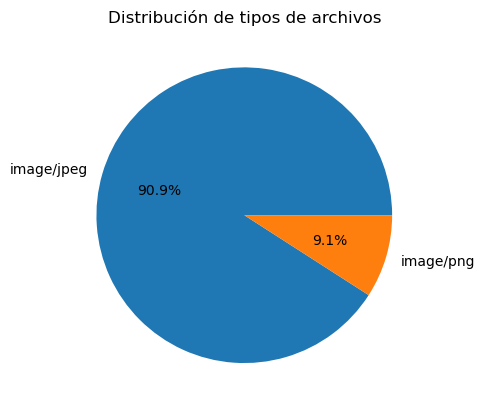

In [68]:
# Verificar si hay datos en el DataFrame
try:
    # Contar la cantidad de archivos por tipo
    conteo = df['Mimetype'].value_counts()

    # Verificar si hay suficientes datos para generar el gráfico de torta
    if len(conteo) > 0:
        # Crear el gráfico de torta
        plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%')

        # Mostrar el gráfico
        plt.title('Distribución de tipos de archivos')
        plt.show()
    else:
        print("No hay suficientes datos para generar el gráfico de torta.")
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos. Realice operaciones de etiquetado antes de usar este código.")


Nuevamente utilizamos el bloque try-except. De ahora en adelante siempre lo asumiremos explicado, para no ser repetitivo

Primero, realizamos una copia de nuestro dataframe para operar sin alterar los datos.

Primero, chequeamos que el archivo tenga imagenes cargadas, viendo la longitud del dataframe

De la columna "Resolucion" convertimos el string en una lista de 2 elementos, luego creamos 2 nuevas columnas que sean el elemento 1 y el elemento 2 de esta lista

Usando los metodos **max** y **min** de pandas encontramos los valores maximos de cada dimension en las columnas correspondientes. Luego, los imprimimos por pantalla.

In [69]:
################################# MAXIMO Y MINIMO DE RESOLUCIÓN ###################################

try:
    # Copiar el dataframe para no sobreescribir los datos
    df_resolucion = df.copy()

    # Verificar si hay suficientes datos para encontrar los valores máximos de altura y ancho
    if len(df_resolucion) > 0:
        # Obtener los valores de altura y ancho de la columna "Resolución"
        

        df_resolucion.loc[:, 'Resolucion'] = df_resolucion['Resolucion'].str.strip('()').str.split(',')
        df_resolucion.loc[:, 'Altura'] = df_resolucion['Resolucion'].apply(lambda x: int(x[0]))
        df_resolucion.loc[:, 'Ancho'] = df_resolucion['Resolucion'].apply(lambda x: int(x[1]))

        # Encontrar los valores más grandes de altura y ancho
        max_height = df_resolucion['Altura'].max()
        max_width = df_resolucion['Ancho'].max()

        # Mostrar los valores máximos de altura y ancho por pantalla
        print(f"""---------------------------------------------------
Dimensiones maximas entre las imagenes etiquetadas
---------------------------------------------------""")
        print(f"Altura máxima: {max_height}")
        print(f"Ancho máximo: {max_width}")
    else:
        print("No hay suficientes datos para encontrar los valores máximos de altura y ancho.")
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos. Realice operaciones de etiquetado antes de usar este código.")

---------------------------------------------------
Dimensiones maximas entre las imagenes etiquetadas
---------------------------------------------------
Altura máxima: 5400
Ancho máximo: 3600


Esta funcion, toma las columnas de Altura y Ancho del dataframe creado en la celda anterior y las plotea utilizando la funcion **scatter** de matplotlib.|

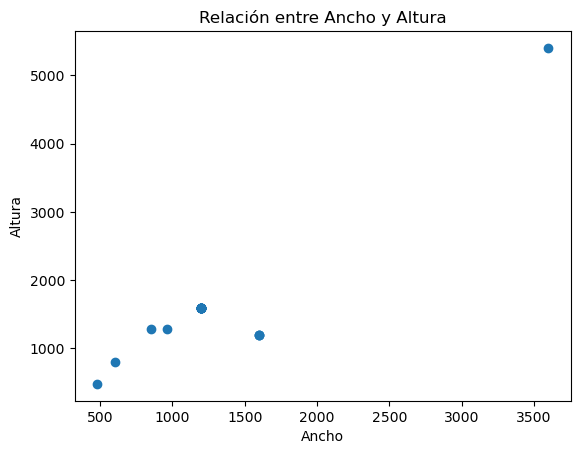

In [70]:
################################### GRÁFICO DE DISPERSIÓN ###########################################

try:
    # Verificar si hay datos en el DataFrame
    conteo = len(df_resolucion)

    # Verificar si hay suficientes datos para generar el gráfico de dispersión
    if conteo > 0:
        # Crear el gráfico de dispersión
        plt.scatter(df_resolucion['Ancho'], df_resolucion['Altura'])
        plt.xlabel('Ancho')
        plt.ylabel('Altura')
        plt.title('Relación entre Ancho y Altura')

        # Mostrar el gráfico de dispersión
        plt.show()
    else:
        print("No hay suficientes datos para generar el gráfico de dispersión.")

except:
    print("Ocurrió un error al verificar los datos del DataFrame.")



La siguiente celda primero stablece el idioma en español utilizando **locale.setlocale()** para asegurarse de que los nombres de los días de la semana se formateen correctamente en español.

Luego, en la columna de fechas en formato datetime ordenamos las fechas utilizando un **sort_values**, las convertimos en formato *dd/mm/aaaa* con **strftime** y finalmente contabilizamos los cambios en cada fecha utilizando **Counter** del modulo collections. Esto se guarda en el objeto diccionario FECHA_SERIES (y se utilizara mas adelante)

Finalmente, hace un grafico de barras con la funcion **bar** en el cual cada dia de la semana ocupa un lugar en el eje x (cada dia de la semana tiene un indice y cada indice es un valor en x) y la altura en y es el valor de cuentas por dia

Los argumentos que le siguen son algunos detalles esteticos del grafico

Primero definimos una funcion llamada **get_dia_semana** que toma como argumento el valor del timestamp para cada fila del dataframe y devuelve el dia de la semana correspondiente a partir del metodo **.weekday()** de datetime que nos da un valor del 0 a 6 correspondiente a cada dia (0 para el lunes, 1 para el martes y asi hasta el 6 para el domingo). 

Además definimos **get_fecha** que toma como argumento el valor del timestamp para cada fila del dataframe y devuelve el dia en formato  *dd/mm/aaaa* con **strftime** 

In [80]:
def get_dia_semana(timestamp):
    '''
    Dado un timestamp, mapea al dia de la semana que se corresponde
    '''

    nombres_dias = {
        0: 'Lunes',
        1: 'Martes',
        2: 'Miercoles',
        3: 'Jueves',
        4: 'Viernes',
        5: 'Sabado',
        6: 'Domingo'
    }

    timestamp = datetime.fromtimestamp(timestamp)

    return nombres_dias[timestamp.weekday()]

def get_fecha(timestamp):
    '''
    Dado un timestamp devuelve la fecha en formato '%d/%m/%Y'.
    '''
    timestamp = datetime.fromtimestamp(timestamp)

    return timestamp.strftime('%d/%m/%Y')


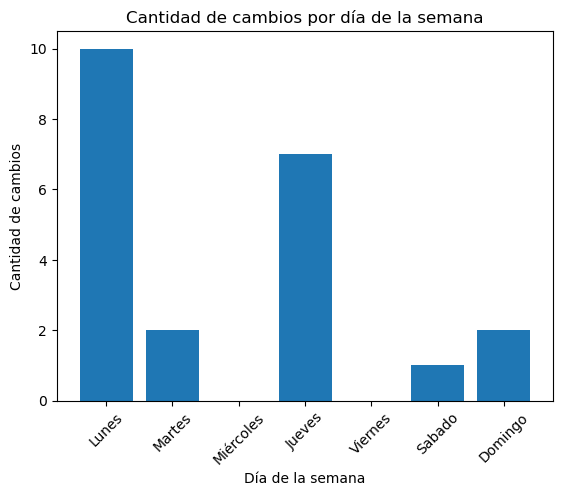

In [81]:
######################################### GRAFICO DE CAMBIOS POR DIA DE LA SEMANA #####################3

# Verificar si hay datos en el DataFrame
try:
    # Establecer el idioma en español
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

    # Convertir la columna "Fecha" en objetos de fecha
    df['Fecha datetime'] = df['Fecha'].map(get_fecha)

    # Obtener el día de la semana y la fecha formateada
    # El día de la semana se obtiene formateado al español
    df['DiaSemana'] = df['Fecha'].map(get_dia_semana)
    
    # Ordenamos las fechas, las formateamos y utilizamos Counter
    # para conocer cuántos cambios se hicieron por fecha
    dias_actualizaciones = df.groupby('Fecha datetime')['Fecha datetime'].count()
    
    # Cuento la cantidad de cambios por día de la semana
    conteo_cambios = df.groupby('DiaSemana')['DiaSemana'].count()

    # Ordenar los días de la semana en el orden deseado
    dias_semana_ordenados = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
    conteo_cambios = conteo_cambios.reindex(dias_semana_ordenados)

    # Verificar si hay suficientes datos para generar el gráfico de barras
    if len(conteo_cambios) > 0:
        # Crear el gráfico de barras
        plt.bar(conteo_cambios.index, conteo_cambios.values)

        # Las etiquetas en x están rotadas en diagonal
        plt.xticks(rotation=45)

        # Agregar título y etiquetas de los ejes
        plt.title('Cantidad de cambios por día de la semana')
        plt.xlabel('Día de la semana')
        plt.ylabel('Cantidad de cambios')

        # Mostrar el gráfico de barras
        plt.show()
    else:
        print("No hay suficientes datos para generar el gráfico de barras.")

except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos. Realice operaciones de etiquetado antes de usar este código.")

De la celda anterior, usamos la variable "dias_actualizaciones", si existieron actulizaciones esta sera >0.

Guardamos en fechas los index del *Series* anterior, es decir, cada una de las fechas donde se realizaron cambios.
En cantidad_actualizaciones guardamos los values, es decir, el resultado de count que nos dice cuantas actualizaciones corresponden a dicha fecha.

Se crea el gráfico de líneas o puntos dependiendo de la cantidad de actualizaciones. Si hay más de una fecha de actualización, se utiliza **.plot()** para crear un gráfico de líneas, y se especifica el parametro **marker='o'** para mostrar puntos (●) en cada fecha. Si solo hay una fecha de actualización, adicionalmente al grafico, se informa por pantalla la fecha de actualizacion.

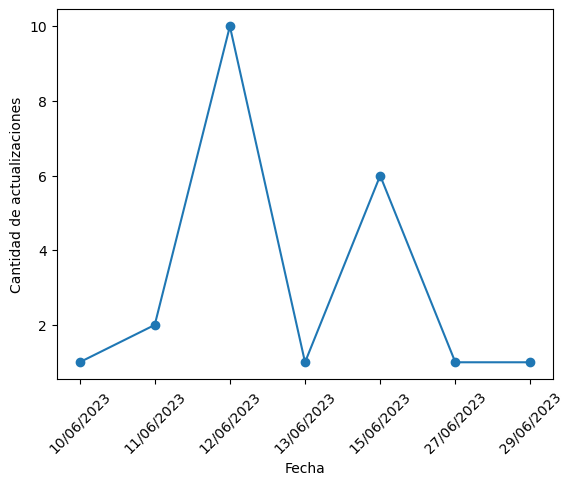

In [79]:
############################# GRAFICO EVOLUTIVO DE LA CANTIDAD DE ACTUALIZACIONES POR FECHA ####################################

try:
    if len(dias_actualizaciones) > 0:
        fechas = dias_actualizaciones.index
        cantidad_actualizaciones = dias_actualizaciones.values

        plt.plot(fechas, cantidad_actualizaciones, marker='o')

        plt.xticks(rotation=45)
        plt.xlabel('Fecha')
        plt.ylabel('Cantidad de actualizaciones')

        if len(dias_actualizaciones) == 1:
            plt.title(f"Solo hubo actualizaciones en la fecha: {df['FechaFormateada'][0]}")

        plt.show()
    else:
        print("No hay suficientes datos para generar el gráfico")
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos o no es un DataFrame válido. Realice operaciones de etiquetado antes de usar este código.")
except NameError:
    print("Asegurese de correr las celdas anteriores")

Primero, nos aseguramos que la columna 'Tags' tenga longitud mayor a 0.

Luego, unimos todos los tags en un unico string, separados por espacios y utilizamos el modulo WordCloud para crear una nube de palabras, con las especificaciones de ancho, alto y color de fondo. El modulo de WordCloud se encarga de proporcionar tamaño a las palabras segun su frecuencia de aparicion.

Utilizando la funcion **imshow** ploteamos la imagen de la nube de palabras usando matplotlib, el parametro "interpolation" se utiliza para calcular los valores de los pixeles de la imagen al redimensionarla.

Al hacer **axis('off')** evitamos que aparezcan los ejes x e y en el grafico

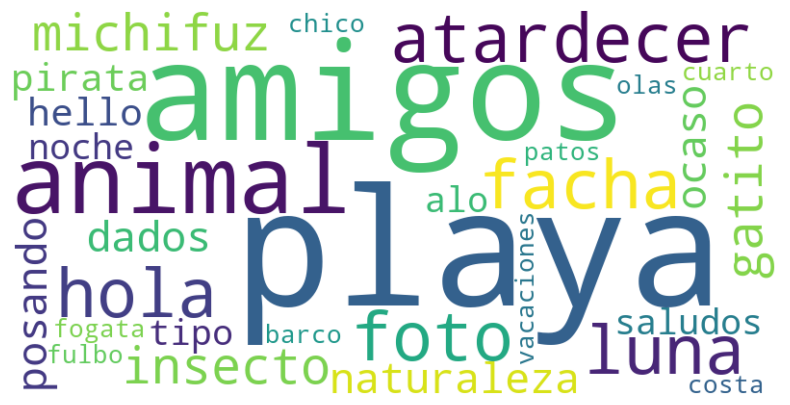

In [7]:
###################################### NUBE DE PALABRAS CON LOS TAGS #################################################

try:
    if len(df['Tags']) > 0:
        # Unir los tags en un solo string separados por espacios
        tags_texto = ' '.join(df['Tags'])

        # Crear la nube de palabras
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tags_texto.lower())

        # Mostrar la nube de palabras
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        print("No hay suficientes datos para generar la nube de palabras.")
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos o no es un DataFrame válido. Realice operaciones de etiquetado antes de usar este código.")


El siguiente codigo guarda en la variable tags_nuemrados todos los strings registrados en la columna "Tags" del dataframe como una unica lista de strings.

Luego crea el diccionario grupos donde a cada tag le asigna la cantidad de veces que aparece a partir del metodo **Counter** y **most_common(3)** que se queda con los 3 tags con mas apariciones.

A continuacion imprimimos por pantalla, en el formato correspondiente, estos valores

In [8]:
################################ RANKING DE TAGS UTILIZADOS ################################

try:
    # Obtener todos los tags de la columna 'Tags'
    df_tags=df.copy()
    
    # Creamos una única lista con todos los tags
    df_tags['Tags'] = df_tags['Tags'].str.lower().str.replace(' ', '').str.split(',')
    
    # Aplicamos Counter para contabilizar las apariciones
    df_tags_separados = df_tags.explode('Tags')
    
    tags_ordenados=df_tags_separados['Tags'].value_counts().sort_values(ascending=False)[0:3]
    

    # Mostrar los tags y sus respectivas cantidades de usos en orden descendente
    print('''------------------------------------------------
           Top 3 tags más utilizados
------------------------------------------------''')
    print(f"Cantidad de usos\tLista de Tags")
    print("________________________________________________")
    print()
    for tag, cuenta in tags_ordenados.items():
        print(f"\t{cuenta}\t\t  {tag}")
    
    
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos o no es un DataFrame válido. Realice operaciones de etiquetado antes de usar este código.")


------------------------------------------------
           Top 3 tags más utilizados
------------------------------------------------
Cantidad de usos	Lista de Tags
________________________________________________

	6		  playa
	4		  amigos
	3		  animal


Creamos un nuevo DataFrame llamado df_usuarios correspondiente al archivo "usuarios.json"

Luego, realizamos un merge entre los Dataframe df y df_usuarios haciendo que a los elementos de la columna "Ultima actualizacion" se les otorgue relacion directa con los elementos de la columna "Alias". La opcion "outer" hace que en la fusion se incluyan los elementos que no se encuentran en la interseccion de columnas.


In [9]:
df_usuarios = pd.read_json(pt.ruta_archivo)
df = pd.merge(df, df_usuarios, left_on='Ultima actualizacion', right_on='Alias', how='outer')

Creamos una copia de df con las columnas que nos interesan (los usuarios y el tamaño de las actualizaciones)

Llenamos los lugares vacion de "Tamaño en MB" con 0.0 para los usuarios que no realizaron cambios.

Agrupamos las filas que correspondan al mismo usuario, haciendo que el nuevo valor de la columna "Tamaño en MB" la media de los valores anteriores utilizando **groupby** y **mean**

Luego, ordenamos esta columna utilizando **sort_values** 

In [10]:
############################# PROMEDIO DE TAMAÑOS DE IMAGEN POR USUARIO ################################

try:
    # Leer las columnas de interés: Última Actualización y Tamaño (MB)
    df_user_size = df[['Alias', 'Tamaño en MB']].copy()
    df_user_size['Tamaño en MB'].fillna(0, inplace=True)
    
    # Agrupar por usuario y calcular el promedio de los tamaños de las imágenes
    df_avg_size = df_user_size.groupby('Alias')['Tamaño en MB'].mean().reset_index()

    # Ordenar el DataFrame por el tamaño promedio en orden descendente
    df_avg_size.sort_values('Tamaño en MB', ascending=False, inplace=True)

    # Crear la lista de tamaños promedio
    avg_sizes = df_avg_size.values.tolist()

    # Imprimir los resultados en formato de tabla
    print('Puesto   Usuario                Tamaño Promedio (MB)')
    print('________________________________________________')
    print()
    for i, (user, avg) in enumerate(avg_sizes, start=1):
        print(f'{i:<6}   {user:<22} {avg:.2f} MB')
except AttributeError:
    print("El archivo 'tagsimagen.csv' no contiene datos o no es un DataFrame válido. Realice operaciones de etiquetado antes de usar este código.")


Puesto   Usuario                Tamaño Promedio (MB)
________________________________________________

1        Tomi                   1.21 MB
2        Batman                 0.40 MB
3        fotos                  0.13 MB
4        Lean                   0.13 MB
5        clari                  0.13 MB
6        jxskier                0.12 MB
7        Carpincho              0.12 MB
8        Ale                    0.10 MB
9        Poisson                0.09 MB
10       Juanchin               0.08 MB
11       Invitado               0.03 MB
12       Pato                   0.00 MB
13       enzosaave              0.00 MB


# Logs del sistema

Ahora leemos el archivo **LogSistema.csv** con pandas guardando un dataframe en la variable "data"

In [12]:
data = pd.read_csv(pt.ruta_archivo_csv)

Con el metodo **.apply()** aplicamos la funcion **dia_semana** a cada valor de la columna **Fecha y hora** y lo guardamos en una nueva columna del dataframe llamada **Dia**

In [13]:
#pasamos la fecha a un dia de la semana
data['Dia'] = data['Fecha y hora'].map(get_dia_semana)


Ahora trabajamos con los datos del dataframe. Por un lado creamos una lista **orden_semana** donde aparecen los 7 dias ordenados y con ella aplicamos la funcion **sorted** donde el argumento **key=lambda x: orden_semana.index(x)** hace que lo ordene de modo tal que queden todas las lineas ordenadas de lunes a domingo.

Luego definimos las listas **colores** y **columnas** que vamos a usar para asignar el color y etiqueta de cada columna del histograma. 

Por ultimo usamos el metodo **Counter** para obtener el numero de repeticiones de cada dia. Como este metodo nos da un diccionario, tomamos por un lado las claves en la lista **dias** y por otro lado el numero de veces que aparece dicho dia en el dataframe en **frecuencia_dias**.

In [14]:
data2=data.copy()

In [15]:
data2 = data2.groupby('Dia')['Dia'].count()


In [16]:
#jugamos con los datos para que quede lindo el histograma
orden_semana = ['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
data2=data2.reindex(orden_semana)


colores = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

dias = data2.index
frecuencia_dias = data2.values


Con todos los datos necesarios para realizar un gráfico comparando los días de la semana en que se realizaron operaciones usando la aplicación, usando la funcion**plt.bar** de la libreria **matplotlib** creamos el histograma. 

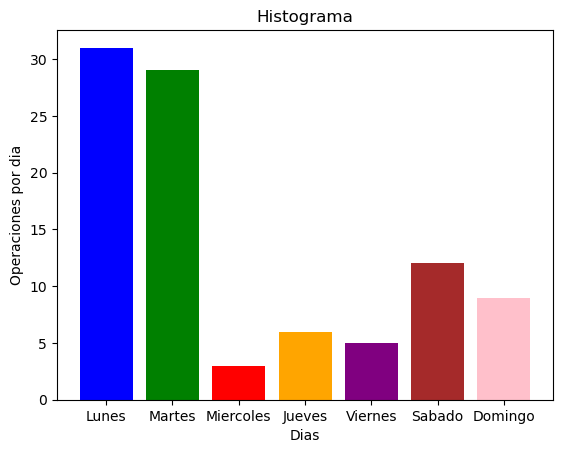

In [17]:
plt.bar(dias, frecuencia_dias, color=colores, label=orden_semana)

plt.xlabel('Dias')
plt.ylabel('Operaciones por dia')
plt.title('Histograma')

plt.show()


Ahora queremos generar un gráfico de barra apilado que muestre las cantidades de operaciones por
Alias. 

Para esto primero usamos el metodo **groupby** de pandas para agrupar por **"Usuario"** y por **"Operacio"**, donde el metodo **.size()** ceunta la cantidad de registros en cada grupo y devuelve una serie que muestra el número de apariciones de cada combinación de usuario y operación. 

Luego, se aplica el método unstack() para reorganizar los datos de forma que los valores de la columna 'Operacion' se convierten en columnas individuales en el DataFrame resultante **Conteo** y cada valor único en la columna **"Operacion"** se convierte en una columna separada y los valores de conteo se llenan en estas columnas. El parámetro **fill_value=0** se utiliza para que se rellene con ceros en caso de que no haya datos disponibles para alguna combinación de usuario y operación.

Después de obtener el DataFrame resultante con los conteos ordenados, se utiliza el método **plot()** para generar un gráfico de barras horizontales apiladas. El parámetro **kind='barh'** se utiliza para especificar el tipo de gráfico como barras horizontales y el parámetro **stacked=True** se utiliza para apilar las barras de cada categoría en lugar de mostrarlas una al lado de la otra.

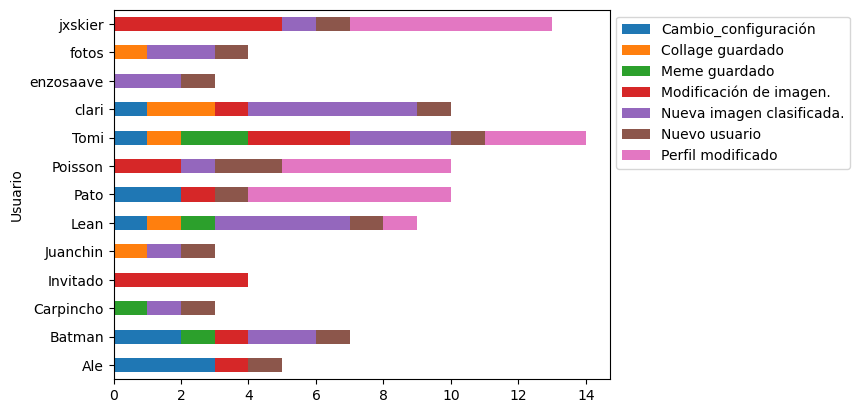

In [18]:
conteo3 = data.groupby(['Usuario', 'Operacion']).size().unstack().plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

Ahora, leemos el archivo "usuarios.json" y realizamos un merge entre las columnas ""Usuario" y "Alias". A partir de esto tendremos, en cada columna de *data* informacion sobre el genero de quien realizo la operacion.



In [19]:
tabla_usuarios = pd.read_json(pt.ruta_archivo)
data = pd.merge(data, tabla_usuarios, left_on='Usuario', right_on='Alias', how='outer')

Primero se utiliza el método **fillna()** para rellenar los valores faltantes en el DataFrame **data**. El valor **np.nan** indica que los valores faltantes se reemplazarán con el valor especial de **NumPy** para representar datos faltantes. El parámetro **inplace=True** se usa para indicar que los cambios se realicen directamente en el DataFrame **data** sin necesidad de asignar el resultado a una nueva variable.

Luego realizamos varias operaciones en la columna **'Genero'** del DataFrame **tabla_usuarios** y generamos un conteo de los valores únicos. Primero aplicamos el metodo **mask** con la condicion de que la columna "Genero" contenga el valor *"Otro"*. Luego, reemplazamos sobre la columna "Genero" todos los valores marcados por mask con los valores de la columna "Genero_alt", para que cada usuario quede definitivamente asociado con su genero.

Luego utilizamos el método **.str.lower()**  a la columna **'Genero'** para convertir todos los valores de texto a minúsculas de modo que no importe como escribieron los generos (mayusculas o minusculas). Despues se utiliza el método **value_counts()** para contar las apariciones de cada valor único en la columna **'Genero'** y el resultado es una Serie que muestra el número de apariciones de cada valor único en la columna.



In [20]:
data.fillna(np.nan, inplace=True)
data['Genero'] = data['Genero'].mask(data['Genero'] == 'Otro').fillna(data['Genero_alt'])
generos = data['Genero'].str.lower().value_counts()
#list(generos.keys())

primero creamos una lista llamada **etiquetas** que contiene las claves o etiquetas de **generos**. Luego usamos el método **plt.pie** para generar un grafico de torta donde aparezcan representados los porcenatajes por genero, donde el parámetro **autopct='%1.1f%%'** es el que hace que aparezca el porcentaje correspondiente a cada region del grafico de torta

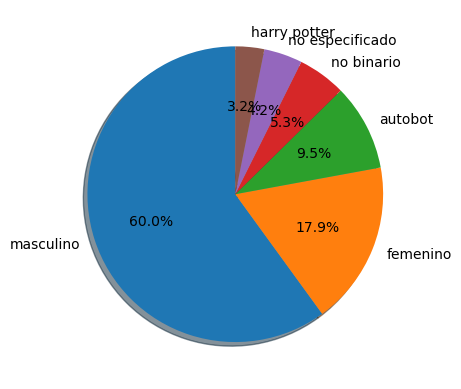

In [21]:
etiquetas=[etiqueta for etiqueta in generos.keys()]

plt.pie(generos, labels=etiquetas, shadow=True, startangle=90, labeldistance= 1.1, autopct='%1.1f%%')

plt.show()

Nuevamente usamos **.groupby** con el método **.size()** para agrupar los datos del dataframe que necesitamos.

In [22]:
conteo = data.groupby(['Operacion']).size()

Ahora queremos hacer un gráfico que refleje las cantidades de cada operación realizada. Para esto primero definimos las listas **colores** y **etiquetas** que vamos a usar para asignar un color y un nombre a cada columna del histograma. 

In [23]:
colores = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet']
etiquetas = list(conteo.index)

Usando la función **plt.bar** de **matplotlib** generamos el histograma. 

**locs = range(len(etiquetas))** crea un rango de valores en funcion en la longitud de la lista etiquetas esto lo usamos para establecer las posiciones de las marcas en el eje x.

**plt.gca().set_xticks(locs)** establece las marcas en el eje x utilizando los valores en locs. Esto indica dónde se colocarán las marcas en el gráfico y **plt.gca().set_xticklabels(etiquetas, rotation=45, ha='right')** establece las etiquetas de las marcas en el eje x utilizando los valores en etiquetas, donde el parámetro **rotation=45** indica que las etiquetas se rotarán 45 grados y el parámetro **ha='right'** alinea las etiquetas a la derecha.

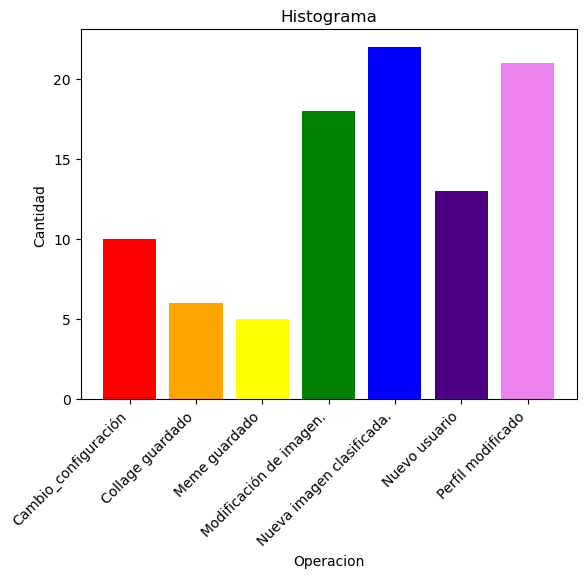

In [24]:
plt.bar(etiquetas, conteo, color=colores, label='')
plt.xlabel('Operacion')
plt.ylabel('Cantidad')
plt.title('Histograma')

plt.xticks(rotation=45, ha='right')


plt.show()

Ahora queremos generar una nube de palabras de los textos agregados en los collages y otra con los
textos agregados en los memes. 

para esto creamos una condición utilizando una comparación para verificar si los valores en la columna **'Operacion'** del DataFrame data son iguales a **"Meme guardado"**, la condición devuelve una serie de valores booleanos que indican si se cumple la condición para cada fila del DataFrame. Luego utilizamos la condición para seleccionar las filas del DataFrame data donde se cumple la misma. 

luego accedemos a la columna **"Textos"** del DataFrame **filas_seleccionadas** y convierte los valores de esa columna en una lista utilizando el método **tolist()** y lo guarmaos en la variable **palabras**.

Para poder hacer la nube de palabras, primero combinamos todas las palabras de la lista **palabras** en un solo texto separado por espacios utilizando el método **join()** y utilizamos el método **replace()** para eliminar las comillas simples ('') del texto, guardando todo en **txto_completo**.

Luego utilizamos el modulo **WordCloud** para crear una nube de palabras, con las especificaciones de ancho, alto y color de fondo. El modulo de **WordCloud** se encarga de proporcionar tamaño a las palabras segun su frecuencia de aparicion. 

Utilizando la funcion **imshow** ploteamos la imagen de la nube de palabras usando **matplotlib**, el parametro **"interpolation"** se utiliza para calcular los valores de los pixeles de la imagen al redimensionarla.

Al hacer **axis('off')** evitamos que aparezcan los ejes x e y en el grafico

In [25]:
condicion = data['Operacion'] == "Meme guardado"
filas_seleccionadas = data[(data['Operacion'] == "Meme guardado")].dropna() 
palabras = filas_seleccionadas["Textos"].tolist()
palabras

["['Bruno, rehaciendo todas las rutas', 'Yo, a las 8 am']",
 "['Terminar el trabajo con tiempo', 'Mi grupo']",
 "['Yo', 'Villanos de Ciudad Gotica']",
 "['Texto 1', 'Texto 2', 'Texto 3', 'Texto 4']",
 "['Modificar una imagen', 'Todo el genero femenino']"]

Para poder hacer la nube de palabras, primero combinamos todas las palabras de la lista **palabras** en un solo texto separado por espacios utilizando el método **join()** y utilizamos el método **replace()** para eliminar las comillas simples ('') del texto, guardando todo en **txto_completo**.

Luego utilizamos el modulo **WordCloud** para crear una nube de palabras, con las especificaciones de ancho, alto y color de fondo. El modulo de **WordCloud** se encarga de proporcionar tamaño a las palabras segun su frecuencia de aparicion. 

Utilizando la funcion **imshow** ploteamos la imagen de la nube de palabras usando **matplotlib**, el parametro **"interpolation"** se utiliza para calcular los valores de los pixeles de la imagen al redimensionarla.

Al hacer **axis('off')** evitamos que aparezcan los ejes x e y en el grafico

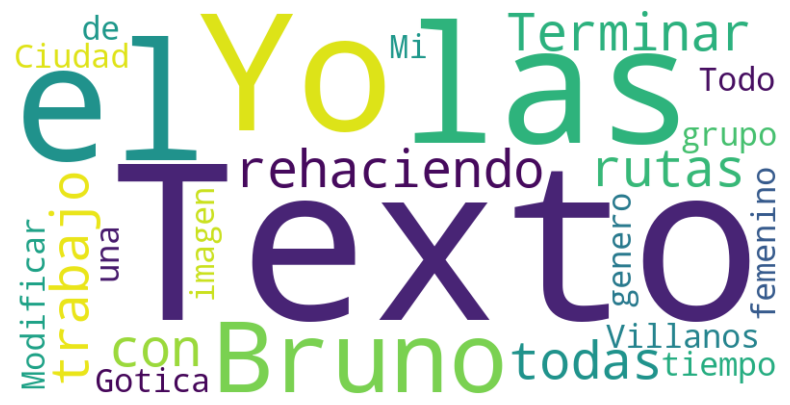

In [26]:
palabras = filas_seleccionadas["Textos"].tolist()
texto_completo = ' '.join(palabras).replace("'","")



# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Repetimos para los titulos del collage

In [27]:
condicion = data['Operacion'] == "Collage guardado"
filas_seleccionadas = data[(data['Operacion'] == "Collage guardado")].dropna() 
palabras = filas_seleccionadas["Textos"].tolist()
palabras

['Un bicho y un gato',
 'veranito 2003',
 'Mis veranos',
 'Tirando Facha',
 'Vacaciones uwu']

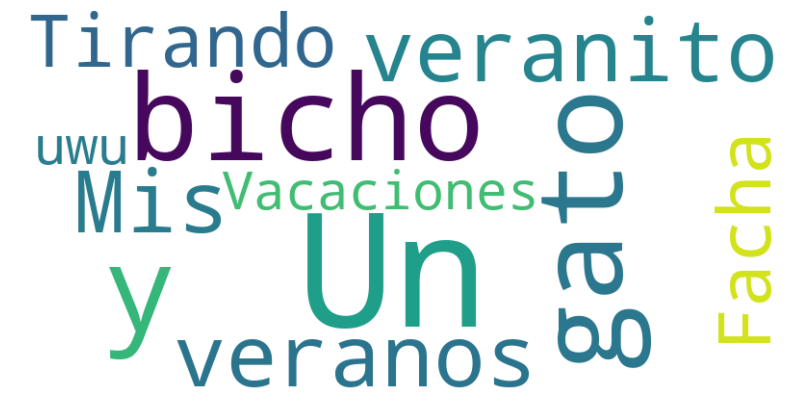

In [28]:
palabras = filas_seleccionadas["Textos"].tolist()
texto_completo = ' '.join(palabras).replace("'","")



# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Lo siguiente que queremos hacer es generar un ranking de las 5 imágenes más usadas para generar memes y otro para generar collages. 

Para esto primero filtramo en el DataFrame data utilizando una condición para seleccionar solo las filas donde el valor en la columna **'Operacion'** es igual a **"Meme guardado"**. La condición se representa como **data[data['Operacion'] == "Meme guardado"]** , que devuelve una serie de valores booleanos que indican si se cumple la condición para cada fila del DataFrame. Luego, utilizamos esta serie de valores booleanos para filtrar el DataFrame original data, creando un nuevo DataFrame llamado **data_filtrado_meme** que contiene solo las filas que cumplen la condición.

In [29]:
data_filtrado_meme = data[data['Operacion'] == "Meme guardado"]

Nuevamente usamos el metodo **Counter** junto con **most_common** para quedarnos con los 5 valores mas comunes de las imagenes en un objeto Counter

Luego convertimos **filtro** en una lista de tuplas donde cada tupla contiene el nombre de cada templante y la cantidad de filas asociadas a ese templante.

In [30]:
#filtro = data_filtrado_meme.groupby("Valores").size().sort_values(ascending=False).head(5)
filtro= Counter(data_filtrado_meme['Valores']).most_common(5)
lista_tuplas_meme = list(filtro)

Finalmente imprimimos el ranking en un formato claro y legible.

In [31]:
print(f"""----------------------------------------------
imágenes más usadas para generar memes
#        imagen          usos
----------------------------------------------""")
i=0
for n in lista_tuplas_meme:
    i += 1
    print(f"#{i}    {n[0]}       {n[1]}")

----------------------------------------------
imágenes más usadas para generar memes
#        imagen          usos
----------------------------------------------
#1    template4.jpg       2
#2    template3.jpg       2
#3    template5.jpg       1


Nuevamente hcemos un filtrado, solo que esta vez sobre el valor **"Collage guardado"**, creamos una copia del DataFrame y usamos el método **.apply()** para aplicar una función lambda a cada valor de la columna y asi separar las multiples imagenes que se usan en cada collage. La función lambda **lambda x: x.replace("'", '"')** reemplaza las comillas simples ('') por comillas dobles (") en cada valor de la columna **'Valores'**. 

In [32]:
data_filtrado_collage = data[data['Operacion'] == "Collage guardado"]
data_collage = data_filtrado_collage.copy()
data_collage=data_collage["Valores"].apply(lambda x: x.replace("'", '"'))

Definimos la función **separar** que toma una cadena y la separa en una lista. Esto es necesario ya que en el archivo **"LogSistema.csv"** las imagenes de collages aparecen en una cadena que respresenta la lista de imagenes usadas y queremos volver a tener una lista con los nombres de las imagenes.

In [33]:
def separar(cadena):
    """ Esta funcion toma un str que representa una lista y la separa
   	 en sus respectivos elementos antes de convertirse en str"""
    
    return [elemento.strip() for elemento in cadena.strip("[]").split(",")]

Usando el método **.apply()** aplicamos la función **separar** a cada valor del DataFrame. Luego utilizamos list comprehenssion para combinar en una sola lista todos los elementos presentes en el DataFrame **data_collage_separado**.

Por ultimo, utilizamos **Counter** para contar la frecuencia de aparición de cada imagen en la lista **imagenes_collage**. El método **.most_common(5)** nos da las 5 imágenes más comunes y devuelve una lista de tuplas, donde cada tupla contiene la imagen y su frecuencia de aparición. 

In [34]:
data_collage_separado = data_collage.apply(separar)
imagenes_collage =  [imagen for sublista in data_collage_separado for imagen in sublista]
imagenes_collage_contadas = Counter(imagenes_collage).most_common(5)

Finalmente imprimimos el ranking en un formato claro y legible.

In [35]:
print(f"""----------------------------------------------
  Imágenes más usadas para generar collages
----------------------------------------------
#     imagen             usos
----------------------------------------------""")
i=0
for n in imagenes_collage_contadas:
    i += 1
    print(f"#{i}    {n[0]:<18} contada {n[1]} veces          ")

----------------------------------------------
  Imágenes más usadas para generar collages
----------------------------------------------
#     imagen             usos
----------------------------------------------
#1    "Vacaciones2.jpg"  contada 3 veces          
#2    "Vacaciones4.jpg"  contada 3 veces          
#3    "Vacaciones6.jpg"  contada 2 veces          
#4    "Vacaciones8.jpg"  contada 2 veces          
#5    "Cat03.jpg"        contada 1 veces          


Por ultimo, con los datos del archivo de perfiles generar un gráfico de torta con los porcentajes
según género de las personas que realizaron las operaciones: **"Nueva imagen clasificada"** y **"Modificación de imagen previamente clasificada"**. 

Para esto primero creamos dos nuevos DataFrames, **op_nc** y **op_mi**, que contienen las filas donde la columna **'Operacion'** tiene los valores **"Nueva imagen clasificada."** y **"Modificación de imagen."** respectivamente

In [115]:
op_tot = data[(data['Operacion'] == "Modificación de imagen." ) | (data['Operacion'] == "Nueva imagen clasificada." )]
op_tot['Genero y operacion']=op_tot['Genero']+'/'+op_tot['Operacion']

/tmp/ipykernel_61873/3929832187.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op_tot['Genero y operacion']=op_tot['Genero']+'/'+op_tot['Operacion']


Utilizamos un **value_counts** sobre las columnas "Genero" de ambos y guardamos el valor en las variables "op_nc_cuentas" y "op_mi_cuentas", respectivamente

In [104]:
op_tot_cuentas_separado = op_tot['Genero y operacion'].value_counts()
op_tot_cuentas_juntos = op_tot['Genero'].value_counts()

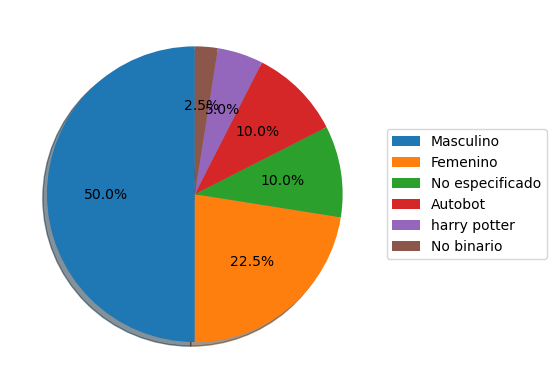

In [113]:

######################## Hacemos el grafico de torta ###########################################################################


plt.pie(op_tot_cuentas_juntos, shadow=True, startangle=90, labeldistance= 1.1, autopct='%1.1f%%')

plt.legend(title='', labels=op_tot_cuentas_juntos.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

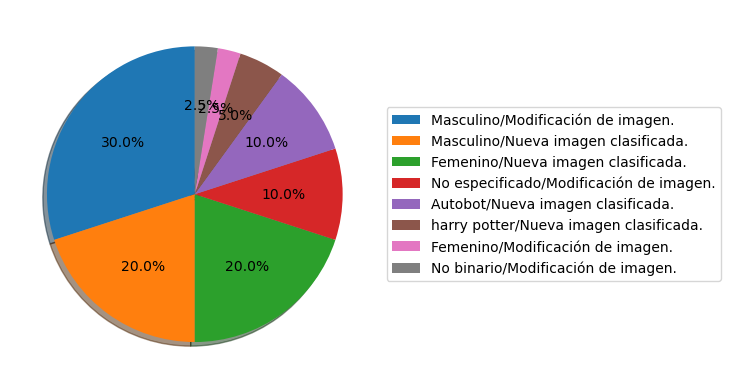

In [114]:
plt.pie(op_tot_cuentas_separado, shadow=True, startangle=90, labeldistance= 1.1, autopct='%1.1f%%')

plt.legend(title='', labels=op_tot_cuentas_separado.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()